## Spatial Segmentation and Key Drivers of Energy Consumption in the UK

*An analysis of consumer groups within the UK energy market and investigating socio-economic factors that influence the consumption patterns of different segments*

In [161]:
# load relevant packages for analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hdbscan

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
from shapely.geometry import Point

### 1.0 Introduction

The purpose of this paper is to segment UK consumers based on energy usage and investigate factors which are highly correlated to high and low energy consumption. 

Following economic sanctions placed on Russian oil in 2022, energy prices in Europe increased dramatically. This led to public discontent and *knee-jerk* relief payments provided by the public sector. While these payments provided short-term relief, investigating the nature of energy consumption in UK and the factors contributing to it can inform more targetted policy which could make the UK more reslient against price shocks and highlight circumstances that contribute to high and low energy consumption.

This paper uses clustering to segment energy consumers at a postcode level and investigates these clusters using multivariable regression.

### 2.0 Literature Review

Developing targetted policy involves market segmentation, segment analysis, implementation and ongoing monitoring (Soto et al., 2021). This paper, due to its analytical nature, will investigate the first two steps.

Segmentation plays a crucial role in developing targeted policies by identifying distinct groups within a population. This enables the creation of finely tuned interventions that are more likely to be effective and meet the needs of different segments (Soto et al., 2021).

Clustering has emerged as a powerful tool to delineate target populations more effectively for policy implementation. Balashankar et al. (2022) illustrate how clustering methods can help segment populations and identify distinct groups crucial for developing effective and targeted policies.

There are many clustering strategies. The most popular of which are Hierarchal, DBSCAN and K-means. DBSCAN and hierarchical clustering are able to effectively handle geographic data with varying shapes and reveal multi-level hierarchical relationships among data points.

From here, targetted policy development investigates segments to ascertain their characteritics. Multivariable regression is frequently used to evaluate the influence of socio-economic and environmental factors on distinct population segments. This approach controls for multiple variables simultaneously, pinpointing the impacts of each factor. By applying this method, researchers can provide precise insights essential for targeted policy formulation. This tailored approach improves the effectiveness and fairness of interventions, addressing the unique needs of different consumer groups (Balashankar et al., 2022).

There are three fields the ONS commonly reports alongside energy consumption. 1. **Central Heating Type**  is crucial for understanding energy consumption as it directly influences the efficiency and amount of energy required to heat homes, making it a pivotal variable for targeted energy-saving interventions. 2. **Income Level** and 3. **Dwelling Type** are similarly important; they reflect the economic capacity to invest in energy-efficient solutions and the physical characteristics of a home that affect energy needs, which can guide the formulation of policies tailored to specific economic and housing conditions.

With this in mind, this paper investgates 2 research questions.

            RQ1 | Can we use spatial clustering to effectively segment the UK population based on electricity and gas consumption behaviour?
            RQ2 | How do central heating type, income level and dwelling type correlate with the energy consumption patterns of different consumer segments?

### 3.0 Methodology

This study will leverage open data from the *Office of National Statistics (ONS)* and energy consumption data from the *UK Department for Energy Security and Net Zero (DESNZ)*. All datasets are from the 2022. 

The energy consumption data provided by DESNZ is at the postcode level, while other fields are provided by Local Authority District (LAD). To overcome this issue we proceed with clustering at a postcode level, then determine which LADs these clusters geographically sit within. If clusters sit within 2 or more LADs, we simply aggregate the energy consumption data from these clusters for each LAD using a weighted average based on the number of postcodes from the cluster falling within each LAD. This method ensures that our analysis accurately reflects the geographical distribution of consumption data while aligning it with the socio-economic data at the LAD level.

As outlined above, this analysis will be conducted in two parts. First, consumer segmentation will done using unsupervised clustering. This will done purely based on variables geography and electricity and gas consumption for several reasons (Rehmatulla et al., 2017). 

Starting with geography and energy consumption keeps the analysis clear and focused, allowing for an understanding of core consumption patterns without the distraction of socio-economic factors. Słupik et al. suggests that this method establishes baseline segments that reflect the interaction between geographic characteristics and energy usage, providing a reference for further analysis (2021). Adopting this phased approach enhances methodological rigour, enabling systematic integration of additional variables and ensuring the analysis remains robust as complexity increases.

Each cluster will be categorised into 4 segments based on quartiles, 1. High, 2. Medium-High, 3. Medium-Low and 4. Low Consumption.

Unsupervised clustering is selected over supervised methods because it effectively identifies natural groupings within the data without prior labeling, crucial for discovering inherent patterns in energy consumption that are not predefined. 

Next, we will determine what characteristics are highly correlated with *High*, *Medium-High*, *Medium-Low* and *Low* energy consumption. Since this analysis aims to inform domestic policy, we select variables that are commonly assciated with previous domestic energy relief, these are income, central heating type and dwelling type. This correlation analysis will be based heavily on multiple linear regression. Given the goal of informing targeted domestic energy policies, multiple linear regression allows for the simultaneous examination of how various predictors influence energy consumption across different segments(Forootan et al., 2022). 

This method not only quantifies the strength of these relationships but also adjusts for the interdependencies among variables, providing a comprehensive and statistically robust basis for policy recommendations (Dou et al., 2023).

### 4.0 Data Overview, Processing & Exploration

This section reads in and processes the data for RQ1 and RQ2. Before moving into our analysis we provide an overview of the fields, explore the shape and distribution of our data and check for outliers and incosistencies which could lead to issues in this study. This will all be conducted in the following section after the cleaning phase of each dataset. 

The energy consumption from the DESNZ is provided at outcode level without geometry. The geopy library automatically finds and builds a geometry column based on outcode. DESNEZ provide mean, median and total electricity and gas consumption data by Kilowatt-hour (kWh). Below we drop both the *Mean* and *Total* consumption column and use *Median* annual electrity and gas consumption as it is least impacted by outliers. For this reason we do not normlise by population.

The [geopy](https://geopy.readthedocs.io/en/stable/) library can only assign one postcode per second and is computationally intensive. As a result, we only run this on the gas consumption data and join electricity data later.

As highlighted, the following is a computational intense process and was run when this analysis was originally conducted. The new CSV file is read in below the following four code chunks.

In [165]:
# read in desnez data
gas_df = pd.read_csv('data/gas_consumption.csv')
elec_df = pd.read_csv('data/electricity_consumption.csv')

# init geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# function to get lat / long
def get_lat_lon(outcode):
    try:
        location = geolocator.geocode(f"{outcode}, United Kingdom")
        return (location.latitude, location.longitude)
    except:
        return (None, None)

# avoid hitting rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# apply to outcode column
gas_df['Latitude_Longitude'] = gas_df['outcode'].apply(lambda x: get_lat_lon(x))

In [443]:
gas_df.head(2)

,outcode,gas_total_cons_kwh,gas_mean_cons_kwh,gas_median_cons_kwh,Latitude_Longitude,geometry
208,BL7,9.206557e+07,14799.159651,13056.46745,"(53.6475723, -2.3929065)",POINT (-2.3929065 53.6475723)
209,BL8,1.917554e+08,12548.614637,11229.51000,"(51.023134299999995, -3.0765783915022147)",POINT (-3.0765783915022147 51.023134299999995)


In [264]:
# convert string coordinates to a point object
def parse_coordinates(coord_tuple):
    try:
        # assume coord_tuple is already a tuple in the form (lat, lon)
        lat, lon = coord_tuple
        return Point(float(lon), float(lat))
    except (ValueError, TypeError):
        return None

# apply to 'Latitude_Longitude'
gas_df['geometry'] = gas_df['Latitude_Longitude'].apply(parse_coordinates)

# remove 'None' rows
gas_df = gas_df[gas_df['geometry'].notna()]

# df to gdf
gas_gdf = gpd.GeoDataFrame(gas_df, geometry='geometry')

# WSG 84
gas_gdf.set_crs(epsg=4326, inplace=True)

# join electricity consumption data by outcode
energycon_gdf = pd.merge(gas_gdf, elec_df, on='outcode', how='left')

# drop total & mean consumption columns
columns_to_drop = ['gas_total_cons_kwh', 'gas_mean_cons_kwh', 'elec_total_cons_kwh', 'elec_mean_cons_kwh', 'Latitude_Longitude']
energycon_gdf = energycon_gdf.drop(columns=columns_to_drop)

# save as .gpkg
energycon_gdf.to_file('energycon.gpkg', driver='GPKG')

In [514]:
# read in processed 'energy consumption data' & check
energycon_gdf = gpd.read_file('energycon.gpkg')
energycon_gdf.head(2)

,outcode,gas_median_cons_kwh,elec_median_cons_kwh,geometry
0,BL7,13056.46745,2909.5,POINT (-2.39291 53.64757)
1,BL8,11229.51000,2573.7,POINT (-3.07658 51.02313)


In [507]:
numeric_cols = energycon_gdf.select_dtypes(include=[np.number])

# descriptive stats
basic_stats = numeric_cols.describe()

# count of non-null entries
nonnull_counts = energycon_gdf.count()

# data types
data_types = energycon_gdf.dtypes

# quantiles
quantiles = numeric_cols.quantile([0.25, 0.5, 0.75])

# correlation matrix
correlation_matrix = numeric_cols.corr()

# display
print("Descriptive Statistics:\n", basic_stats)
print("\nCount of Non-Null Entries:\n", nonnull_counts)
print("\nData Types:\n", data_types)
print("\nQuantiles:\n", quantiles)
print("\nCorrelation Matrix:\n", correlation_matrix)

Basic Descriptive Statistics:
        gas_median_cons_kwh  elec_median_cons_kwh
count          2008.000000           1652.000000
mean           9974.120934           2585.591129
std            2341.607527            362.580198
min            3361.726966           1384.000000
25%            8793.258157           2363.225000
50%            9730.088537           2517.250000
75%           10767.478354           2747.025000
max           46419.616774           5444.500000

Count of Non-Null Entries:
 outcode                 2008
gas_median_cons_kwh     2008
elec_median_cons_kwh    1652
geometry                2008
dtype: int64

Data Types:
 outcode                   object
gas_median_cons_kwh      float64
elec_median_cons_kwh     float64
geometry                geometry
dtype: object

Quantiles:
       gas_median_cons_kwh  elec_median_cons_kwh
0.25          8793.258157              2363.225
0.50          9730.088537              2517.250
0.75         10767.478354              2747.025

Corr

#### Given the following summary statistics we can infer the following conclusions about our data:
- The data encompasses records from 2,008 outcodes, with median gas consumption varying widely from about 3,362 to 46,420 kWh, indicating significant regional differences. The median gas consumption for most areas hovers around 9,730 kWh.
- Electricity consumption data, available for 1,652 outcodes, shows less variability than gas, with a median consumption typically around 2,517 kWh. There is a moderate correlation (approximately 0.39) between gas and electricity consumption, suggesting that areas with higher gas usage also tend to have higher electricity usage, albeit to a lesser extent.

However, there is a discrepancy between the counts of gas and electricity consumption. This suggests there is inconsistencies or missing entries, which may lead to biased analysis outcomes if unaddressed. Secondly we must ensure data integrity of 'geometry' column. This is conducted in the following code chunk.

In [525]:
# drop na values
energycon_gdf = energycon_gdf.dropna(subset=['elec_median_cons_kwh'])

# check for invalid geometries
invalid_geometries = energycon_gdf['geometry'].is_valid
if invalid_geometries.any():
    energycon_gdf['geometry'] = energycon_gdf['geometry'].buffer(0)

# verify CRS is EPSG:4326
if energycon_gdf.crs is None:
    energycon_gdf.set_crs(epsg=4326, inplace=True)

Below, we read and process the socio-economic data for the clustering and segmentation analysis. There are five fields taken from four datasets recorded by LAD. The population, dwelling type, central heating type and income data all comes from the ONS. This data is merged with LAD polygon data, also provided by the ONS. 

The socio-economic data is provided as raw counts, thus, we conduct per capita normalisation to ensure our analysis is accurate. During the normalisation process we deal with NaN and 0 values.

In [451]:
# read in ONS socioeconomic & LAD geometry data
income = pd.read_csv('data/annual_income.csv') # annual income
heat_type = pd.read_csv('data/heating_type.csv') # central heating type
dw_type = pd.read_csv('data/accomodation_type.csv') # dwelling type
lad = gpd.read_file("data/Local_Authority_Districts/LAD_MAY_2022_UK_BFE_V3.shp") # lad polygon data
pop = pd.read_excel("data/population.xlsx") # pop

In [453]:
# process and clean income data
median_income = income.groupby('Local authority code')['Total annual income (£)'].median().reset_index()

# rename 'med average annual income' & print
median_income.rename(columns={'Total annual income (£)': 'Med average annual income (£)'}, inplace=True)
median_income.rename(columns={'Local authority code': 'Lower tier local authorities Code'}, inplace=True)
median_income.head(2)

,Lower tier local authorities Code,Med average annual income (£)
0,E06000001,31050.0
1,E06000002,35500.0


In [455]:
# process heating & dwelling type data
# pivot heating type
heatpivot_df = heat_type.pivot(
    index='Lower tier local authorities Code',
    columns='Type of central heating in household (5 categories)',
    values='Observation'
)

# 'LAD Code' as index
heatpivot_df.reset_index(inplace=True)

# pivot 'dw type'
dwpivot_df = dw_type.pivot(index='Lower tier local authorities Code', 
                         columns='Accommodation type (5 categories)', 
                         values='Observation')

# 'LAD Code' as index
dwpivot_df.reset_index(inplace=True)

In [457]:
# merge 'dwpivot_df' and 'heatpivot_df' on 'Lower tier local authorities Code'
merged_df = pd.merge(dwpivot_df, heatpivot_df, on='Lower tier local authorities Code', how='outer')

# merge with 'income' on 'Lower tier local authorities Code'
socec_df = pd.merge(merged_df, median_income, on='Lower tier local authorities Code', how='outer')

# display
socec_df.head(2)

,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Med average annual income (£)
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,0.0,342.0,36686.0,180.0,3722.0,31050.0
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,0.0,752.0,53648.0,178.0,5684.0,35500.0


In [459]:
# merge 'LAD' and 'socec_df' geographic data
lad_filtered = lad[['LAD22CD', 'geometry']]

# keep all 'socec_df' columns and only 'geometry' from 'lad'
socec_df = pd.merge(socec_df, lad_filtered, how='left', left_on='Lower tier local authorities Code', right_on='LAD22CD')

# drop 'LAD22CD' & display
socec_df.drop(columns=['LAD22CD'], inplace=True)

In [461]:
# final cleaning
# drop
socec_df.drop(columns=['Does not apply'], inplace=True)

# rename index as 'LAD'
socec_df.rename(columns={'Lower tier local authorities Code': 'LAD'}, inplace=True)

# geometry as last column
geometry = socec_df.pop('geometry')
socec_df['geometry'] = geometry

# rename
column_rename_map = {
    'A caravan or other mobile or temporary structure': 'dwelling_type: mobile',
    'Flat, maisonette or apartment': 'dwelling_type: flat',
    'Whole house or bungalow: Detached': 'dwelling_type: detached house',
    'Whole house or bungalow: Semi-detached': 'dwelling_type: semi-detached',
    'Whole house or bungalow: Terraced': 'dwelling_type: terraced',
    'Does not have central heating': 'no central heating',
    'Has one type of central heating': '1 central heating',
    'Two or more types of central heating (including renewable energy)': '2+ central heating (renewable)',
    'Two or more types of central heating (not including renewable energy)': '2+ central heating (non-renewable)',
    'Med average annual income (£)': 'mean annual income'
}
socec_df.rename(columns=column_rename_map, inplace=True)

# print
socec_df.head(2)

,LAD,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,342.0,36686.0,180.0,3722.0,31050.0,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,752.0,53648.0,178.0,5684.0,35500.0,"POLYGON ((448489.897 522071.798, 448592.597 52..."


In [463]:
# normalise these values by the population of each LAD 
# start by adding population to df:
# left join data using 'socec_df' as master
pop_filtered = pop[['Code', 'All ages']]
socec_df = pd.merge(socec_df, pop_filtered, how='left', left_on='LAD', right_on='Code')

# rename 'All ages' column to 'population' and drop redundant 'Code' column
socec_df.rename(columns={'All ages': 'population'}, inplace=True)
socec_df.drop(columns=['Code'], inplace=True)

In [536]:
# normalise all the necessary fields
# columns to normalise
columns_to_normalise = [
    'dwelling_type: mobile', 'dwelling_type: flat', 'dwelling_type: detached house',
    'dwelling_type: semi-detached', 'dwelling_type: terraced',
    'no central heating', '1 central heating',
    '2+ central heating (renewable)', '2+ central heating (non-renewable)'
]

# remove rows where pop is NaN / 0
cleaned_df = socec_df[socec_df['population'].notna() & (socec_df['population'] > 0)]

# new df for normalised data
nsocec_df = cleaned_df[['LAD', 'geometry', 'mean annual income']].copy()

# normalise each column by population & display
for column in columns_to_normalise:
    nsocec_df[column] = cleaned_df[column] / cleaned_df['population']
nsocec_df.head(2)

,LAD,geometry,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable)
0,E06000001,"POLYGON ((447213.900 537036.104, 447228.798 53...",31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654
1,E06000002,"POLYGON ((448489.897 522071.798, 448592.597 52...",35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332


In [544]:
# convert to gdf using epsg:4326
nsocec_gdf = gpd.GeoDataFrame(nsocec_df, geometry='geometry')
nsocec_gdf.set_crs("epsg:4326", inplace=True, allow_override=True)
nsocec_gdf.head(2)

,LAD,geometry,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable)
0,E06000001,"POLYGON ((447213.89950 537036.10450, 447228.79...",31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654
1,E06000002,"POLYGON ((448489.89690 522071.79790, 448592.59...",35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332


The socioeconomic data is merged and formatted. Below we produce the summary statistics for each field.

In [546]:
# summary statistics for numeric fields
numeric_stats = nsocec_gdf.describe()

# statistics for 'geometry'
if 'geometry' in nsocec_gdf.columns:
    geometry_types = nsocec_gdf['geometry'].geom_type.value_counts()

# numeric statistics
print("Numeric Fields Summary Statistics:\n", numeric_stats)

# print the geometry statistics
if 'geometry' in nsocec_gdf.columns:
    print("\nGeometry Types:\n", geometry_types)

Numeric Fields Summary Statistics:
        mean annual income  dwelling_type: mobile  dwelling_type: flat  \
count          301.000000             314.000000           314.000000   
mean         46630.232558               0.002067             0.082017   
std           9870.109740               0.002098             0.065401   
min          31050.000000               0.000000             0.017910   
25%          39000.000000               0.000503             0.044090   
50%          44600.000000               0.001333             0.063788   
75%          53350.000000               0.002957             0.094242   
max         101800.000000               0.013217             0.443809   

       dwelling_type: detached house  dwelling_type: semi-detached  \
count                     314.000000                    314.000000   
mean                        0.108347                      0.130504   
std                         0.055624                      0.037655   
min                       

The average mean annual income across the 301 entries is approximately £46,630, but the range is quite broad, with a maximum income reported as £101,800. The normalized dwelling data reveals a predominance of flats and semi-detached houses, with relatively minor variations in central heating systems, suggesting a general uniformity in dwelling types and heating across the sampled regions.

The presence of missing data in 'mean annual income' alongside its lack of normalisation may skew comparative analyses, especially when juxtaposed against other per capita normalised metrics. The mix of Polygon and MultiPolygon geometries in the dataset necessitates careful handling to ensure accuracy in spatial operations and consistency in geographic analyses.

In [ ]:
# Addressing missing data in 'mean annual income'
print(f"Missing data in 'mean annual income' before cleanup: {nsocec_df['mean annual income'].isna().sum()}")
nsocec_df['mean annual income'].fillna(nsocec_df['mean annual income'].median(), inplace=True)
print(f"After imputing missing values with median: {nsocec_df['mean annual income'].isna().sum()}")

# Normalizing 'mean annual income' if not already normalized
if 'mean annual income per capita' not in nsocec_df.columns:
    nsocec_df['mean annual income per capita'] = nsocec_df['mean annual income'] / nsocec_df['population']

# Ensuring geometry consistency for accurate spatial operations
nsocec_df['geometry'] = nsocec_df['geometry'].apply(lambda x: x if x.is_valid else x.buffer(0))
nsocec_df = nsocec_df.explode()  # This will handle MultiPolygons by turning them into multiple Polygon entries

# Checking for and correcting any data type inconsistencies
nsocec_df['mean annual income'] = pd.to_numeric(nsocec_df['mean annual income'], errors='coerce')

# Final data types and cleanup status report
print("\nFinal Data Types in DataFrame:")
print(nsocec_df.dtypes)

### 5.0 Analysis

Ensure to break this section down into separate sections of analysis. This helps with clarity and coherency of analysis.

#### 5.1 Segmentation of UK Energy Consumers: Clustering

Segmenting UK energy consumers by behavior is essential for crafting effective energy policies. Identifying groups based on their usage patterns allows for tailored interventions that meet specific needs. Understanding the key factors driving energy consumption in these segments enhances efficiency and promotes sustainability, supporting the UK's environmental goals.Below, we conduct unsupervised spatial clustering to identify groupings

In [76]:
# read in consumption data
gdf = gpd.read_file('ukge_consumption.gpkg')
gdf.head()

,outcode,ngas_median_cons_kwh,nelec_median_cons_kwh,geometry
0,AL1,0.287219,0.069271,POINT (-1.23428 54.57754)
1,AL10,0.253254,0.064801,POINT (-0.22457 51.77064)
2,AL2,0.511699,0.120507,POINT (-1.23429 54.57725)
3,AL3,0.423208,0.095952,POINT (-0.33501 51.76730)
4,AL4,0.424410,0.103246,POINT (-0.24983 51.73707)


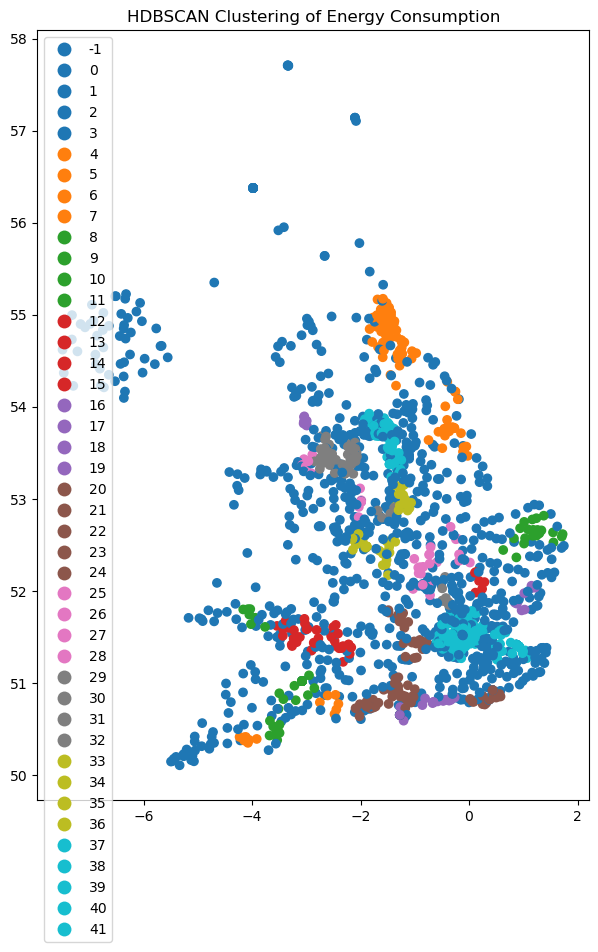

In [78]:
# conduct spatial clusterin  using hdbscan
# extract x, y values from geometry column
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# prepare data for clustering & initialise hdbscan
X = gdf[['ngas_median_cons_kwh', 'nelec_median_cons_kwh', 'x', 'y']]

# initialise hdbscan
# min_cluster_size = 5
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# fit model
cluster_labels = clusterer.fit_predict(X)

# assign the cluster labels to a gdf
gdf['cluster'] = cluster_labels

# plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='cluster', categorical=True, legend=True, ax=ax)
ax.set_title('HDBSCAN Clustering of Energy Consumption')
plt.show()

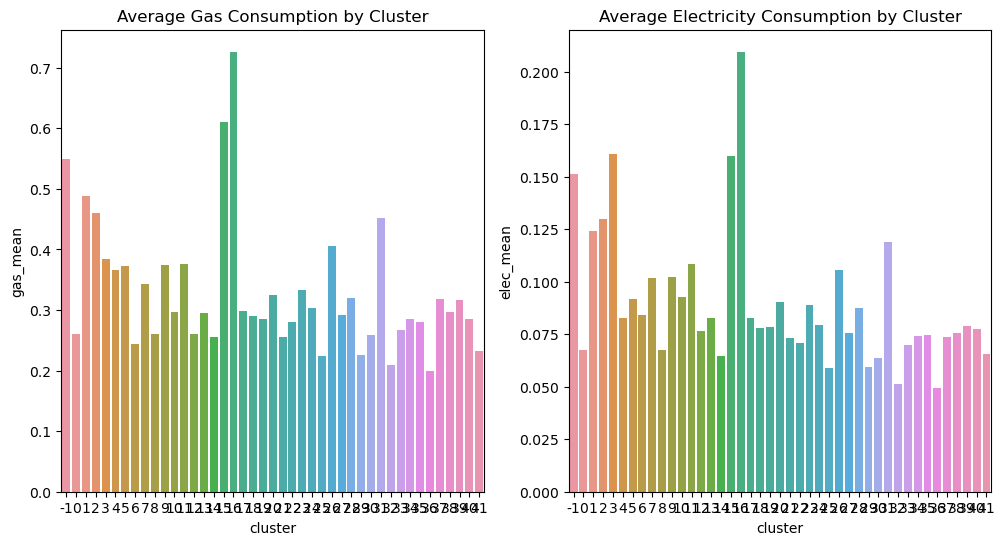

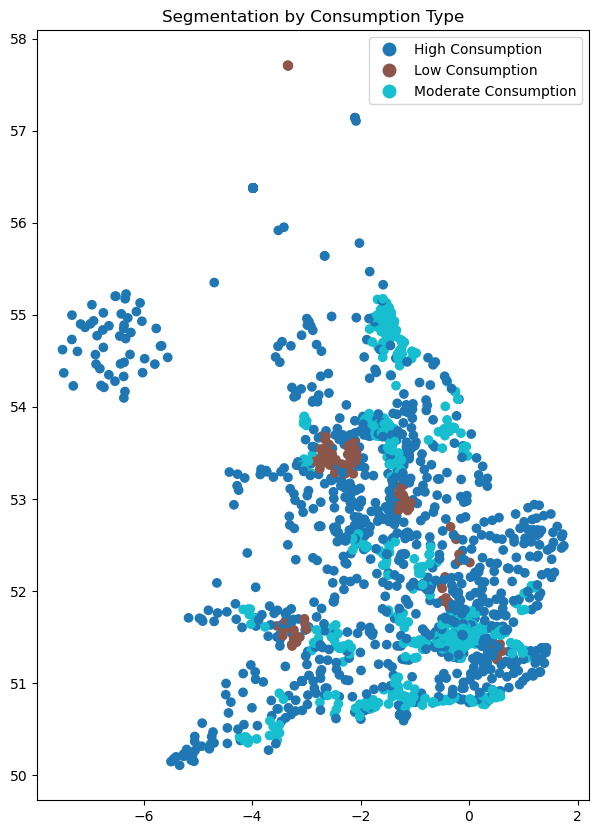

In [80]:
cluster_summary = gdf.groupby('cluster').agg({
    'ngas_median_cons_kwh': ['mean', 'median', 'std'],
    'nelec_median_cons_kwh': ['mean', 'median', 'std']
}).reset_index()

# rename columns
cluster_summary.columns = ['cluster', 'gas_mean', 'gas_median', 'gas_std', 'elec_mean', 'elec_median', 'elec_std']

# visualise average gas and electricity consumption by cluster
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x='cluster', y='gas_mean', data=cluster_summary, ax=ax[0])
ax[0].set_title('Average Gas Consumption by Cluster')
sns.barplot(x='cluster', y='elec_mean', data=cluster_summary, ax=ax[1])
ax[1].set_title('Average Electricity Consumption by Cluster')
plt.show()

# define high & low consumption segment population based on mean consumption by quartiles
gas_upper_quartile = cluster_summary['gas_mean'].quantile(0.75)
elec_upper_quartile = cluster_summary['elec_mean'].quantile(0.75)
gas_lower_quartile = cluster_summary['gas_mean'].quantile(0.25)
elec_lower_quartile = cluster_summary['elec_mean'].quantile(0.25)
# define
def segment_population(row):
    if row['gas_mean'] > gas_upper_quartile and row['elec_mean'] > elec_upper_quartile:
        return 'High Consumption'
    elif row['gas_mean'] < gas_lower_quartile and row['elec_mean'] < elec_lower_quartile:
        return 'Low Consumption'
    else:
        return 'Moderate Consumption'

# segment using cluster summary data
cluster_summary['consumption_type'] = cluster_summary.apply(segment_population, axis=1)

# map consumption types into gdf based on clusters
consumption_mapping = cluster_summary.set_index('cluster')['consumption_type'].to_dict()
gdf['consumption_type'] = gdf['cluster'].map(consumption_mapping)

# visualise the segmentation by consumption type using spatial data
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='consumption_type', categorical=True, legend=True, ax=ax)
ax.set_title('Segmentation by Consumption Type')
plt.show()

In [82]:
# calc info about each cluster
cluster_summary

,cluster,gas_mean,gas_median,gas_std,elec_mean,elec_median,elec_std,consumption_type
0,-1,0.549445,0.502223,0.295278,0.151318,0.139292,0.083571,High Consumption
1,0,0.259964,0.192341,0.160714,0.067687,0.052630,0.041181,Low Consumption
2,1,0.488928,0.429622,0.281072,0.124296,0.095785,0.084687,High Consumption
3,2,0.460066,0.333394,0.294544,0.130142,0.115356,0.089014,High Consumption
4,3,0.384379,0.324353,0.127731,0.160944,0.146535,0.067723,High Consumption
5,4,0.365762,0.322758,0.165124,0.082918,0.071975,0.036543,Moderate Consumption
6,5,0.372168,0.349666,0.157009,0.092011,0.085876,0.036576,Moderate Consumption
7,6,0.243813,0.241601,0.086758,0.084175,0.079269,0.030356,Moderate Consumption
8,7,0.342397,0.356309,0.042769,0.102053,0.106431,0.023423,Moderate Consumption
9,8,0.261244,0.252337,0.042140,0.067450,0.069401,0.009389,Moderate Consumption


#### 5.2 Factors Contributing to Segment Energy Consumption: Multilogistic Regression Analysis

In [ ]:
# load cleaned & normalised data as 'gdf'
gdf = gpd.read_file('normalised_energyconsumption_df.gpkg')
# check
gdf.head()

### 6.0 Discussion

#### References

Balashankar, A. et al. (2022) ‘Targeted policy recommendations using outcome-aware clustering’, ACM SIGCAS/SIGCHI Conference on Computing and Sustainable Societies (COMPASS). doi:10.1145/3530190.3534797. 

Dou, Y., Tan, S. and Xie, D. (2023) ‘Comparison of machine learning and statistical methods in the field of Renewable Energy Power Generation Forecasting: A mini review’, Frontiers in Energy Research, 11. doi:10.3389/fenrg.2023.1218603. 

Forootan, M.M. et al. (2022) ‘Machine learning and deep learning in energy systems: A Review’, Sustainability, 14(8), p. 4832. doi:10.3390/su14084832. 

Rehmatulla, N., Calleya, J. and Smith, T. (2017) ‘The implementation of technical energy efficiency and CO 2 emission reduction measures in shipping’, Ocean Engineering, 139, pp. 184–197. doi:10.1016/j.oceaneng.2017.04.029. 

Słupik, S., Kos-Łabędowicz, J. and Trzęsiok, J., 2021. An innovative approach to energy consumer segmentation—a behavioural perspective. the case of the eco-bot project. Energies, 14(12), p.3556.
